#                                **Electricity Consumption Using Time Series Analysis**

## Loading the basic libraries

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.stattools import acf, pacf
# from statsmodels.tsa.arima_model import ARIMA

Loading Electric Production data set

In [3]:
elecom = pd.read_csv('./Electric_Production.csv')

Let's check first 5 and last 5 records of data set

In [4]:
elecom.head(5)

,DATE,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151


In [5]:
elecom.tail(5)

,DATE,Value
392,09-01-2017,98.6154
393,10-01-2017,93.6137
394,11-01-2017,97.3359
395,12-01-2017,114.7212
396,01-01-2018,129.4048


In [6]:
elecom.shape

(397, 2)

In [7]:
elecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    397 non-null    object 
 1   Value   397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


There are 397 records in datasets and 2 columns. There are no null records present. But, look at the DATE column. We need to convert them in to datetime datatype.

In [8]:
from datetime import datetime
elecom['DATE']=pd.to_datetime(elecom['DATE'],infer_datetime_format=True)

In [9]:
elecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    397 non-null    datetime64[ns]
 1   Value   397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


Now, we will need to index DATE column.

In [10]:
elecomind = elecom.set_index('DATE',inplace=False)

In [11]:
elecomind.head()


,Value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


Let's plot the data

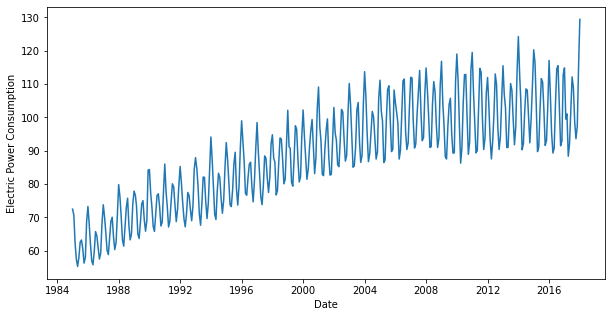

In [12]:
plt.figure(figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Electric Power Consumption')
plt.plot(elecomind)

From the above plot, we can see that there is a Trend compoenent in the series. Hence, we now check for stationarity of the data.

Let's make one function consisting of stationary data checking and ADCF test working. Because we will need to repeat the steps many times, therefore, making function will become very handy.

In [13]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    plt.figure(figsize=(10,5))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    elecom_test = adfuller(timeseries['Value'], autolag='AIC')
    dfoutput = pd.Series(elecom_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in elecom_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Let's determine & plot rolling statistics.

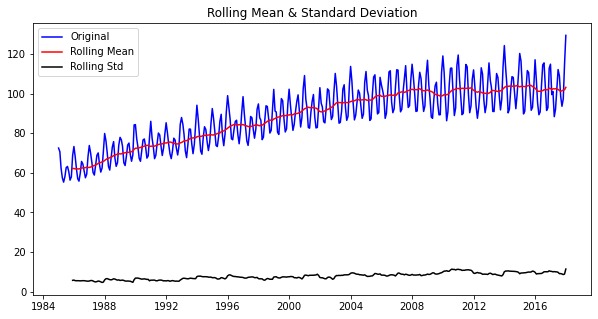

Results of Dickey Fuller Test:


NameError: name 'adfuller' is not defined

In [14]:
test_stationarity(elecomind)

From above plot, we can see that Rolling Mean itself has a trend component even though Rolling Standard Deviation is fairly constant with time.

For time series to be stationary, we need to ensure that both Rolling Mean and Rolling Standard Deviation remain fairly constant WRT time.

Both the curves needs to be parallel to X-Axis, in our case it is not so.

We've also conducted the ADCF ie Augmented Dickey Fuller Test. Having the Null Hypothesis to be Time Series is Non Stationary.

For a Time series to be stationary, the ADCF test should have:

1-p-value should be low (according to the null hypothesis)

2-The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics From the above ADCF test result, we can see that p-value(near to 0.18) is very large. Also critical values lower than Test Statistics. Hence, we can safely say that our Time Series at the moment is NOT STATIONARY

Data Transformation To Achieve Stationarity
Now, we will have to perform some data transformation to achieve Stationarity. We can perform any of the transformations like taking log scale, square, square root, cube, cube root, time shift, exponential decay, etc.

Let's perform Log Transformation.

Basically we need to remove the trend component.

In [15]:
elecom_log = np.log(elecomind)

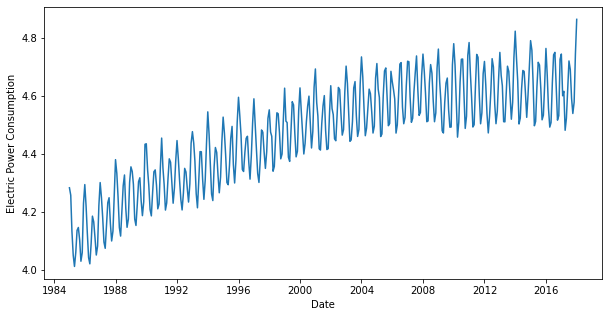

In [16]:
plt.figure(figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Electric Power Consumption')
plt.plot(elecom_log)

Working on Rolling stats seperately (not using function) because we would need Rolling stats separately for computing

In [17]:
rollmean_log = elecom_log.rolling(window=12).mean()
rollstd_log = elecom_log.rolling(window=12).std()

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation (Logarithmic Scale)')

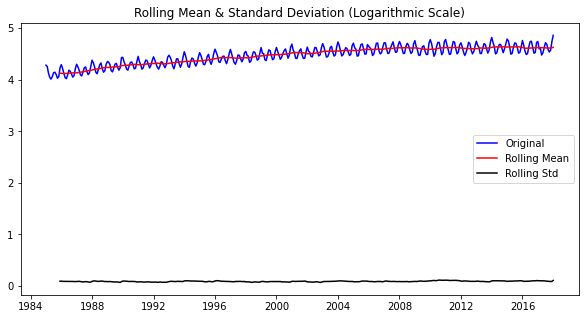

In [18]:
plt.figure(figsize=(10,5))
plt.plot(elecom_log, color='blue', label='Original')
plt.plot(rollmean_log, color='red', label='Rolling Mean')
plt.plot(rollstd_log, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation (Logarithmic Scale)')

From above graph we can say that, we slightly bettered our previous results. Now, we are heading into the right direction.

From the above graph, Time series with log scale as well as Rolling Mean(moving avg) both have the trend component. Thus subtracting one from the other should remove the trend component.

R (result) = Time Series Log Scale - Rolling Mean Log Scale -> this can be our final non trend curve.

In [19]:
elecom_new = elecom_log - rollmean_log

In [20]:
elecom_new.head()


,Value
DATE,
1985-01-01,NaN
1985-02-01,NaN
1985-03-01,NaN
1985-04-01,NaN
1985-05-01,NaN


In [21]:
elecom_new.dropna(inplace=True)

In [22]:
elecom_new.head()

,Value
DATE,
1985-12-01,0.103961
1986-01-01,0.167724
1986-02-01,0.095629
1986-03-01,0.007329
1986-04-01,-0.079115


Let's determine & plot rolling statistics.

Time Shift Transformation

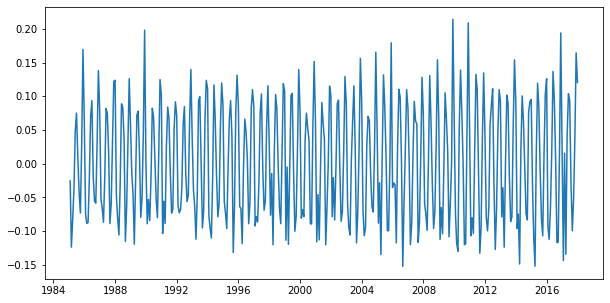

In [24]:
elecom_log_diff = elecom_log - elecom_log.shift()
plt.figure(figsize=(10,5))
plt.plot(elecom_log_diff)

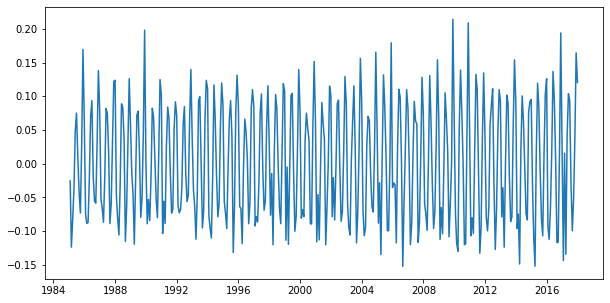

In [25]:
elecom_log_diff.dropna(inplace=True)
plt.figure(figsize=(10,5))
plt.plot(elecom_log_diff)